In [1]:
import os
import pandas as pd
import nltk
from tensorflow.keras import Input, regularizers, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Concatenate, Dropout, LSTM, GRU
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, Concatenate
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
from google.colab import files

# Загружаем файл
uploaded = files.upload()

Saving bert_sentence.csv to bert_sentence.csv


In [117]:
df = pd.read_csv("bert_sentence.csv")
df.head()

,Unnamed: 0.1,Unnamed: 0,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,0,0,"[0.05245498567819595, 0.5145626664161682, -0.0...",2024-10-09,5,54,0,0,0
1,1,1,"[-0.1686820238828659, 0.6197441220283508, -0.1...",2024-10-09,5,195,0,0,0
2,2,2,"[-0.40249526500701904, 0.5722190737724304, -0....",2024-10-09,5,17,0,0,0
3,3,3,"[-0.39001303911209106, 0.5532811880111694, -0....",2024-10-09,5,33,0,0,0
4,4,4,"[-0.36473825573921204, 0.5338039994239807, -0....",2024-10-09,5,15,0,0,0


In [118]:
import ast
df["User review"] = df["User review"].apply(ast.literal_eval)

In [119]:
df.head()

,Unnamed: 0.1,Unnamed: 0,User review,Review date,Star review,Text length,Has media,Has answer,Written by bot
0,0,0,"[0.05245498567819595, 0.5145626664161682, -0.0...",2024-10-09,5,54,0,0,0
1,1,1,"[-0.1686820238828659, 0.6197441220283508, -0.1...",2024-10-09,5,195,0,0,0
2,2,2,"[-0.40249526500701904, 0.5722190737724304, -0....",2024-10-09,5,17,0,0,0
3,3,3,"[-0.39001303911209106, 0.5532811880111694, -0....",2024-10-09,5,33,0,0,0
4,4,4,"[-0.36473825573921204, 0.5338039994239807, -0....",2024-10-09,5,15,0,0,0


In [121]:
type(df['User review'][0])

list

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    2416 non-null   int64 
 1   Unnamed: 0      2416 non-null   int64 
 2   User review     2416 non-null   object
 3   Review date     2416 non-null   object
 4   Star review     2416 non-null   int64 
 5   Text length     2416 non-null   int64 
 6   Has media       2416 non-null   object
 7   Has answer      2416 non-null   int64 
 8   Written by bot  2416 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 170.0+ KB


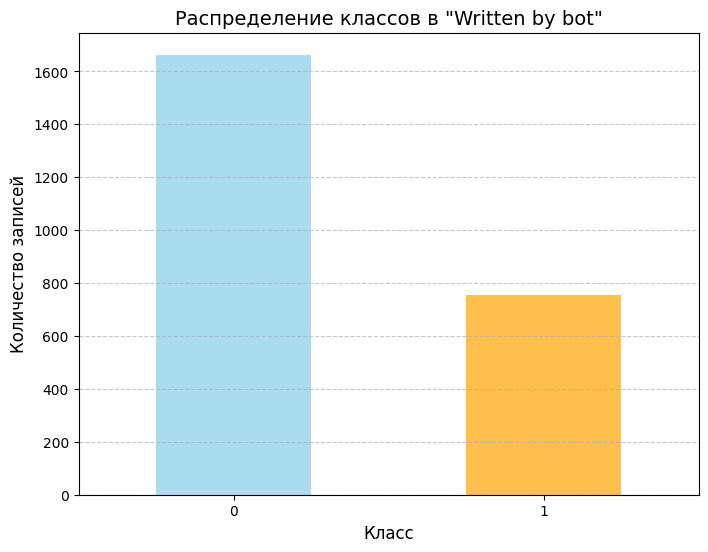

In [123]:
df_balance = df.copy()
class_counts = df['Written by bot'].value_counts()
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7)
plt.title('Распределение классов в "Written by bot"', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество записей', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [124]:
df['Review date'] = pd.to_datetime(df['Review date'], errors='coerce')
df['year'] = df['Review date'].dt.year
df['month'] = df['Review date'].dt.month
df['day'] = df['Review date'].dt.day
target = df['Written by bot']
df = df.drop(columns=["Review date"])
df.head()

,Unnamed: 0.1,Unnamed: 0,User review,Star review,Text length,Has media,Has answer,Written by bot,year,month,day
0,0,0,"[0.05245498567819595, 0.5145626664161682, -0.0...",5,54,0,0,0,2024.0,10.0,9.0
1,1,1,"[-0.1686820238828659, 0.6197441220283508, -0.1...",5,195,0,0,0,2024.0,10.0,9.0
2,2,2,"[-0.40249526500701904, 0.5722190737724304, -0....",5,17,0,0,0,2024.0,10.0,9.0
3,3,3,"[-0.39001303911209106, 0.5532811880111694, -0....",5,33,0,0,0,2024.0,10.0,9.0
4,4,4,"[-0.36473825573921204, 0.5338039994239807, -0....",5,15,0,0,0,2024.0,10.0,9.0


In [125]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], errors='ignore')


In [126]:
df.head()

,User review,Star review,Text length,Has media,Has answer,Written by bot,year,month,day
0,"[0.05245498567819595, 0.5145626664161682, -0.0...",5,54,0,0,0,2024.0,10.0,9.0
1,"[-0.1686820238828659, 0.6197441220283508, -0.1...",5,195,0,0,0,2024.0,10.0,9.0
2,"[-0.40249526500701904, 0.5722190737724304, -0....",5,17,0,0,0,2024.0,10.0,9.0
3,"[-0.39001303911209106, 0.5532811880111694, -0....",5,33,0,0,0,2024.0,10.0,9.0
4,"[-0.36473825573921204, 0.5338039994239807, -0....",5,15,0,0,0,2024.0,10.0,9.0


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   User review     2416 non-null   object 
 1   Star review     2416 non-null   int64  
 2   Text length     2416 non-null   int64  
 3   Has media       2416 non-null   object 
 4   Has answer      2416 non-null   int64  
 5   Written by bot  2416 non-null   int64  
 6   year            2392 non-null   float64
 7   month           2392 non-null   float64
 8   day             2392 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 170.0+ KB


In [95]:
df['Has media'] = df['Has media'].replace({'True': 1, 'False': 0})
df['Has media'].value_counts()

,count
Has media,
0,1684
1,708
0,15
1,9


In [128]:
df['Has media'] = df['Has media'].replace({'1': 1, '0': 0})
df['Has media'].value_counts()

,count
Has media,
0,1684
1,708
False,15
True,9


In [129]:
#df["User review"] = np.stack(df["User review"].values)
print(df)
y = df['Written by bot']
X = df.drop(columns=['Written by bot']).values

                                            User review  Star review  \
0     [0.05245498567819595, 0.5145626664161682, -0.0...            5   
1     [-0.1686820238828659, 0.6197441220283508, -0.1...            5   
2     [-0.40249526500701904, 0.5722190737724304, -0....            5   
3     [-0.39001303911209106, 0.5532811880111694, -0....            5   
4     [-0.36473825573921204, 0.5338039994239807, -0....            5   
...                                                 ...          ...   
2411  [-0.19254209101200104, 0.2736349403858185, -0....            4   
2412  [-0.14071008563041687, 0.6368123888969421, -0....            3   
2413  [-0.05592663213610649, 0.5805096626281738, -0....            4   
2414  [-0.2300054281949997, 0.393181174993515, -0.05...            4   
2415  [-0.21155598759651184, 0.610514760017395, 0.01...            3   

      Text length Has media  Has answer  Written by bot    year  month   day  
0              54         0           0               0 

In [130]:
type(df['User review'][0])

list

In [131]:
nan_counts = df.isna().sum()
df = df.fillna(0)
nan_counts = df.isna().sum()
print(nan_counts)

User review       0
Star review       0
Text length       0
Has media         0
Has answer        0
Written by bot    0
year              0
month             0
day               0
dtype: int64


In [101]:
y, X = df['Written by bot'], df.drop(columns=['Written by bot'])

Исходное распределение классов: Counter({0: 1663, 1: 753})


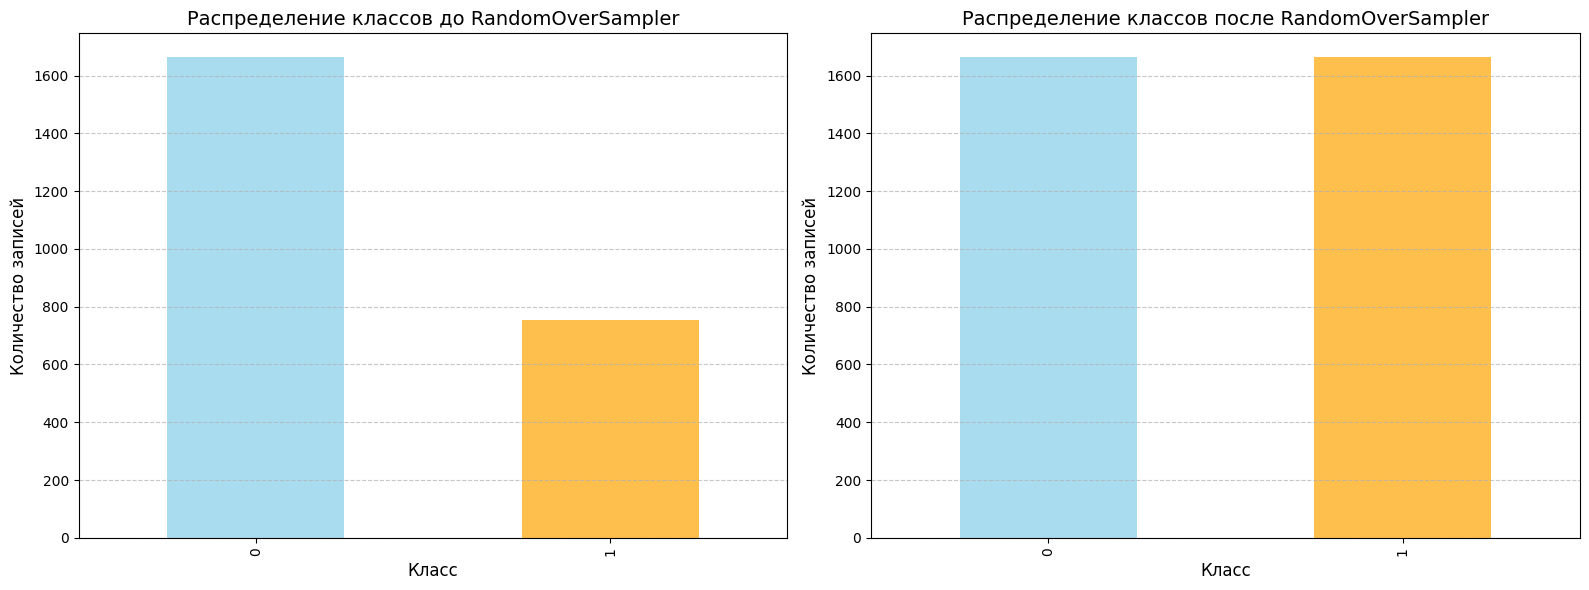

In [134]:
print("Исходное распределение классов:", Counter(y))

ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X, y)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

class_counts_before = y.value_counts()
class_counts_before.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[0])
axes[0].set_title('Распределение классов до RandomOverSampler', fontsize=14)
axes[0].set_xlabel('Класс', fontsize=12)
axes[0].set_ylabel('Количество записей', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

class_counts_after = pd.Series(y_ros).value_counts()
class_counts_after.plot(kind='bar', color=['skyblue', 'orange'], alpha=0.7, ax=axes[1])
axes[1].set_title('Распределение классов после RandomOverSampler', fontsize=14)
axes[1].set_xlabel('Класс', fontsize=12)
axes[1].set_ylabel('Количество записей', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   User review     2416 non-null   object 
 1   Star review     2416 non-null   int64  
 2   Text length     2416 non-null   int64  
 3   Has media       2416 non-null   object 
 4   Has answer      2416 non-null   int64  
 5   Written by bot  2416 non-null   int64  
 6   year            2416 non-null   float64
 7   month           2416 non-null   float64
 8   day             2416 non-null   float64
dtypes: float64(3), int64(4), object(2)
memory usage: 170.0+ KB


In [147]:
X_ros_df = pd.DataFrame(X_ros, columns=df.drop(columns=['Written by bot']).columns)
X_ros_text = X_ros_df['User review']
X_ros_numeric = X_ros_df.drop(columns=['User review'])

In [139]:
X_ros_text.info()

<class 'pandas.core.series.Series'>
RangeIndex: 3326 entries, 0 to 3325
Series name: User review
Non-Null Count  Dtype 
--------------  ----- 
3326 non-null   object
dtypes: object(1)
memory usage: 26.1+ KB


In [155]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_text = pd.DataFrame(X_ros_text, columns=["User review"])
reviews_list = X_text["User review"].tolist()

assert all(isinstance(review, list) for review in reviews_list), "Некоторые элементы не являются списками!"

padded_reviews = pad_sequences(reviews_list, padding='post', dtype='float32')

# Преобразуем в тензор
X_text = tf.convert_to_tensor(padded_reviews, dtype=tf.float32)
print(X_text)

tf.Tensor(
[[ 0.05245499  0.51456267 -0.03691729 ... -0.3253499   0.8491985
   0.28516218]
 [-0.16868202  0.6197441  -0.13351029 ... -0.48548326  0.4668896
   0.1326456 ]
 [-0.40249527  0.5722191  -0.03581284 ... -0.03123894  1.1645935
  -0.07387884]
 ...
 [-0.10106056  0.79523087 -0.01102384 ... -0.19553602  0.6694038
   0.10167704]
 [ 0.1336416   0.49487948 -0.1027125  ... -0.2612953   0.7213744
   0.22887821]
 [-0.08558481  0.51379484 -0.0538251  ... -0.44879958  0.810148
   0.41896054]], shape=(3326, 384), dtype=float32)


In [156]:
X_ros_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3326 entries, 0 to 3325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Star review  3326 non-null   object
 1   Text length  3326 non-null   object
 2   Has media    3326 non-null   object
 3   Has answer   3326 non-null   object
 4   year         3270 non-null   object
 5   month        3270 non-null   object
 6   day          3270 non-null   object
dtypes: object(7)
memory usage: 182.0+ KB


In [47]:
X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_ros_numeric, y_ros, test_size=0.2, random_state=42, stratify=y_ros
)

# Проверяем размеры выборок
print(f"Размеры текстовых данных:")
print(f"X_train_text: {X_train_text.shape}, X_test_text: {X_test_text.shape}")
print(f"Размеры числовых данных:")
print(f"X_train_num: {X_train_num.shape}, X_test_num: {X_test_num.shape}")
print(f"Размеры меток:")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3326 entries, 0 to 3325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Star review  3326 non-null   object
 1   Text length  3326 non-null   object
 2   Has media    3326 non-null   object
 3   Has answer   3326 non-null   object
 4   year         3270 non-null   object
 5   month        3270 non-null   object
 6   day          3270 non-null   object
dtypes: object(7)
memory usage: 182.0+ KB


GlobalPooling2D

In [40]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [44]:
import keras_tuner as kt

save_directory = "pooling_directory"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

def build_model(hp):

    maxlen = 1000
    text_input = Input(shape=(maxlen,), name='text_input')
    x_text = Embedding(1001, hp.Int('embedding_dim', min_value=16, max_value=128, step=16))(text_input)
    x_text = GlobalAveragePooling1D()(x_text)
    x_text = Dense(hp.Int('dense_units', min_value=16, max_value=128, step=16), activation='relu')(x_text)

    # Входные данные для числовых признаков
    num_input = Input(shape=(7,), name='num_input')
    x_num = Dense(32, activation='relu')(num_input)

    # Слияние текстовых и числовых признаков
    combined = Concatenate()([x_text, x_num])

    # Основное тело нейросети
    x = combined
    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', min_value=0.001, max_value=0.1, step=0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
                  activation='relu',
                  kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)


    # Выходной слой
    output = Dense(2, activation='softmax')(x)

    # Компиляция модели
    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='pooling_directory',
    project_name='hyperparameter_tuning'
)

tuner.search(
    [X_train_text, X_train_num], y_train,
    epochs=10,
    validation_data=([X_test_text, X_test_num], y_test)
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)


model = tuner.hypermodel.build(best_hps)

history = model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32
)


test_loss, test_accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

Reloading Tuner from pooling_directory/hyperparameter_tuning/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
48                |16                |embedding_dim
112               |16                |dense_units
4                 |5                 |num_layers
l2                |l1                |reg_type_0
0.008             |0.044             |reg_value_0
128               |128               |units_0
0.5               |0.3               |dropout_0
sgd               |rmsprop           |optimizer
l2                |l1_l2             |reg_type_1
0.06              |0.083             |reg_value_1
192               |256               |units_1
0.3               |0.4               |dropout_1
l2                |l1_l2             |reg_type_2
0.001             |0.009             |reg_value_2
64                |64                |units_2
0.1               |0.5               |dropout_2
l2                |l1_l2             |reg_type_3
0.016             |0

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ke

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/optree/ops.py", line 766, in tree_map
    return treespec.unflatten(map(func, *flat_args))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: Invalid dtype: object


In [ ]:
!zip -r pooling_directory.zip pooling_directory
from google.colab import files
files.download('pooling_directory.zip')

  adding: pooling_directory/ (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/ (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/trial_0017/ (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/trial_0017/checkpoint.weights.h5 (deflated 51%)
  adding: pooling_directory/hyperparameter_tuning/trial_0017/build_config.json (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/trial_0017/trial.json (deflated 90%)
  adding: pooling_directory/hyperparameter_tuning/trial_0014/ (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/trial_0014/checkpoint.weights.h5 (deflated 42%)
  adding: pooling_directory/hyperparameter_tuning/trial_0014/build_config.json (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/trial_0014/trial.json (deflated 89%)
  adding: pooling_directory/hyperparameter_tuning/trial_0023/ (stored 0%)
  adding: pooling_directory/hyperparameter_tuning/trial_0023/checkpoint.weights.h5 (deflated 47%)
  adding: pooling_direct

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LSTM

In [ ]:
save_directory = "lstm_directory"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

def build_model(hp):
    maxlen = 1000
    text_input = Input(shape=(maxlen,), name='text_input')

    embedding_dim = hp.Int('embedding_dim', min_value=16, max_value=128, step=16)
    x_text = Embedding(input_dim=1001, output_dim=embedding_dim)(text_input)

    lstm_units = hp.Int('lstm_units', min_value=16, max_value=128, step=16)
    x_text = LSTM(lstm_units)(x_text)
    x_text = Dense(64, activation='relu')(x_text)

    num_input = Input(shape=(7,), name='num_input')
    x_num = Dense(32, activation='relu')(num_input)

    combined = Concatenate()([x_text, x_num])

    # Основное тело нейросети
    x = combined
    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', min_value=0.001, max_value=0.1, step=0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
                  activation='relu',
                  kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)

    # Выходной слой
    output = Dense(2, activation='softmax')(x)

    # Компиляция модели
    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Создаем Tuner для поиска гиперпараметров
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='lstm_directory',
    project_name='hyperparameter_tuning'
)

tuner.search(
    [X_train_text, X_train_num], y_train,
    epochs=10,
    validation_data=([X_test_text, X_test_num], y_test)
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)


model = tuner.hypermodel.build(best_hps)

history = model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32
)


test_loss, test_accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

Reloading Tuner from lstm_directory/hyperparameter_tuning/tuner0.json
{'embedding_dim': 32, 'lstm_units': 16, 'num_layers': 1, 'reg_type_0': 'l1_l2', 'reg_value_0': 0.006, 'units_0': 256, 'dropout_0': 0.2, 'optimizer': 'adam', 'reg_type_1': 'l1_l2', 'reg_value_1': 0.011, 'units_1': 128, 'dropout_1': 0.5, 'reg_type_2': 'l1', 'reg_value_2': 0.044000000000000004, 'units_2': 128, 'dropout_2': 0.2, 'reg_type_3': 'l1_l2', 'reg_value_3': 0.010000000000000002, 'units_3': 256, 'dropout_3': 0.5, 'reg_type_4': 'l2', 'reg_value_4': 0.09, 'units_4': 64, 'dropout_4': 0.4, 'reg_type_5': 'l1', 'reg_value_5': 0.09, 'units_5': 128, 'dropout_5': 0.30000000000000004, 'reg_type_6': 'l1_l2', 'reg_value_6': 0.002, 'units_6': 256, 'dropout_6': 0.4, 'reg_type_7': 'l2', 'reg_value_7': 0.098, 'units_7': 128, 'dropout_7': 0.4, 'reg_type_8': 'l2', 'reg_value_8': 0.044000000000000004, 'units_8': 192, 'dropout_8': 0.5, 'reg_type_9': 'l1', 'reg_value_9': 0.056, 'units_9': 128, 'dropout_9': 0.1, 'tuner/epochs': 10, 't

GRU

In [ ]:
save_directory = "gru_directory"
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

def build_model(hp):
    maxlen = 1000
    text_input = Input(shape=(maxlen,), name='text_input')

    embedding_dim = hp.Int('embedding_dim', min_value=16, max_value=128, step=16)
    x_text = Embedding(input_dim=1001, output_dim=embedding_dim)(text_input)

    gru_units = hp.Int('gru_units', min_value=16, max_value=128, step=16)
    x_text = GRU(gru_units)(x_text)
    x_text = Dense(64, activation='relu')(x_text)

    num_input = Input(shape=(7,), name='num_input')
    x_num = Dense(32, activation='relu')(num_input)

    combined = Concatenate()([x_text, x_num])

    # Основное тело нейросети
    x = combined
    for i in range(hp.Int('num_layers', 1, 10)):
        reg_type = hp.Choice(f'reg_type_{i}', ['l1', 'l2', 'l1_l2'])
        reg_value = hp.Float(f'reg_value_{i}', min_value=0.001, max_value=0.1, step=0.001)

        if reg_type == 'l1':
            reg = regularizers.l1(reg_value)
        elif reg_type == 'l2':
            reg = regularizers.l2(reg_value)
        else:
            reg = regularizers.l1_l2(l1=reg_value, l2=reg_value)

        x = Dense(hp.Int(f'units_{i}', min_value=64, max_value=256, step=64),
                  activation='relu',
                  kernel_regularizer=reg)(x)
        x = Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1))(x)

    # Выходной слой
    output = Dense(2, activation='softmax')(x)

    # Компиляция модели
    model = Model(inputs=[text_input, num_input], outputs=output)
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    hyperband_iterations=2,
    directory='gru_directory',
    project_name='hyperparameter_tuning'
)

tuner.search(
    [X_train_text, X_train_num], y_train,
    epochs=10,
    validation_data=([X_test_text, X_test_num], y_test)
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)


model = tuner.hypermodel.build(best_hps)

history = model.fit(
    [X_train_text, X_train_num], y_train,
    validation_data=([X_test_text, X_test_num], y_test),
    epochs=10,
    batch_size=32
)


test_loss, test_accuracy = model.evaluate([X_test_text, X_test_num], y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

Reloading Tuner from gru_directory/hyperparameter_tuning/tuner0.json
{'embedding_dim': 112, 'gru_units': 112, 'num_layers': 1, 'reg_type_0': 'l2', 'reg_value_0': 0.032, 'units_0': 128, 'dropout_0': 0.30000000000000004, 'optimizer': 'adam', 'reg_type_1': 'l2', 'reg_value_1': 0.065, 'units_1': 192, 'dropout_1': 0.2, 'reg_type_2': 'l1', 'reg_value_2': 0.099, 'units_2': 64, 'dropout_2': 0.1, 'reg_type_3': 'l1_l2', 'reg_value_3': 0.089, 'units_3': 64, 'dropout_3': 0.30000000000000004, 'reg_type_4': 'l1_l2', 'reg_value_4': 0.08700000000000001, 'units_4': 192, 'dropout_4': 0.2, 'reg_type_5': 'l1_l2', 'reg_value_5': 0.005, 'units_5': 128, 'dropout_5': 0.4, 'reg_type_6': 'l2', 'reg_value_6': 0.030000000000000002, 'units_6': 64, 'dropout_6': 0.30000000000000004, 'reg_type_7': 'l2', 'reg_value_7': 0.07300000000000001, 'units_7': 192, 'dropout_7': 0.4, 'reg_type_8': 'l1', 'reg_value_8': 0.047, 'units_8': 192, 'dropout_8': 0.2, 'reg_type_9': 'l1', 'reg_value_9': 0.069, 'units_9': 64, 'dropout_9': 0